<a href="https://colab.research.google.com/github/shahg1122/Final_PResent/blob/master/Univariate_analysis_using_different_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import keras
import tensorflow
import statsmodels.tsa as sm 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMAResults, ARIMA
from statsmodels.graphics import tsaplots
from statsmodels.graphics.gofplots import qqplot
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
import seaborn as sns
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, LSTM, Activation, Bidirectional, Flatten, TimeDistributed, SimpleRNN, Dropout, GRU, Input, Add, Multiply
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras import optimizers, initializers
from keras.regularizers import l2
from keras.initializers import TruncatedNormal, Constant, RandomNormal


In [3]:
Dataset_SF_site1 = pd.read_excel('/content/sample_data/Solar station site 1 (Nominal capacity-50MW).xlsx').drop(index=0)

In [5]:
Dataset_SF_site1["Time(year-month-day h:m:s)"] = pd.to_datetime(Dataset_SF_site1["Time(year-month-day h:m:s)"])

In [6]:
Dataset_SF_site1.dtypes

Time(year-month-day h:m:s)             datetime64[ns]
Total solar irradiance (W/m2)                   int64
Direct normal irradiance (W/m2)                 int64
Global horizontal irradiance (W/m2)             int64
Air temperature  (°C)                         float64
Atmosphere (hpa)                              float64
Power (MW)                                    float64
dtype: object

In [7]:
dataset = Dataset_SF_site1[['Time(year-month-day h:m:s)', 'Power (MW)']]
dataset.set_index('Time(year-month-day h:m:s)')

,Power (MW)
Time(year-month-day h:m:s),
2019-01-01 00:15:00,0.0
2019-01-01 00:30:00,0.0
2019-01-01 00:45:00,0.0
2019-01-01 01:00:00,0.0
2019-01-01 01:15:00,0.0
...,...
2020-12-31 22:45:00,0.0
2020-12-31 23:00:00,0.0
2020-12-31 23:15:00,0.0


In [8]:
dataset['Time(year-month-day h:m:s)'] = pd.to_datetime(dataset['Time(year-month-day h:m:s)'])
dataset = dataset.resample('D', on='Time(year-month-day h:m:s)').sum()
dataset.head()

<ipython-input-8-b07478037ad7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Time(year-month-day h:m:s)'] = pd.to_datetime(dataset['Time(year-month-day h:m:s)'])


,Power (MW)
Time(year-month-day h:m:s),
2019-01-01,742.942043
2019-01-02,828.307102
2019-01-03,825.291114
2019-01-04,546.541179
2019-01-05,822.351376


In [10]:
np.random.seed(2019) # for initializing models with same weights every time.
validation_split = 0.25 #for train-test split of dataset.

In [11]:
#metrics:
#root mean squared error:
def RMSE(y_true, y_pred): 
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

#mean absolute percentage error
def MAPE(y_true, y_pred): 
    mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100
    return mape

#symmetric mean absolute error
def SMAPE(y_true, y_pred):
    smape = 100/len(y_true) * np.sum(2 * np.abs(np.array(y_pred) - np.array(y_true)) / (np.abs(np.array(y_true)) + np.abs(np.array(y_pred))))
    return smape

#mean squared logarithmic error:
def MSLE(y_true, y_pred):
    rmse = mean_squared_log_error(y_true, y_pred)
    return rmse

In [13]:
scaler = MinMaxScaler(feature_range=(0, 1))
df = pd.DataFrame({"Power":scaler.fit_transform(np.array(dataset['Power (MW)']).reshape(len(dataset),1)).reshape(len(dataset),)},
                  index = dataset.index)
df.head()

,Power
Time(year-month-day h:m:s),
2019-01-01,0.517645
2019-01-02,0.577124
2019-01-03,0.575022
2019-01-04,0.380803
2019-01-05,0.572974


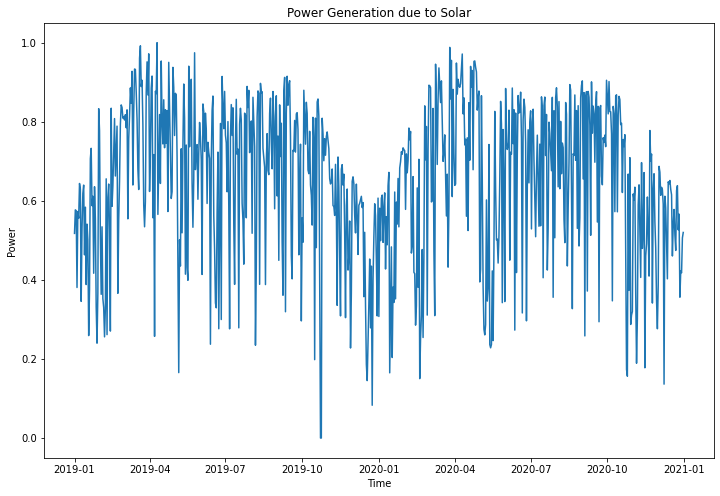

In [14]:
plt.figure(figsize=(12,8))
plt.plot(df)
plt.xlabel('Time')
plt.ylabel('Power')
plt.title('Power Generation due to Solar')
plt.savefig('fig1.png', dpi=800, quality=95)
plt.show()

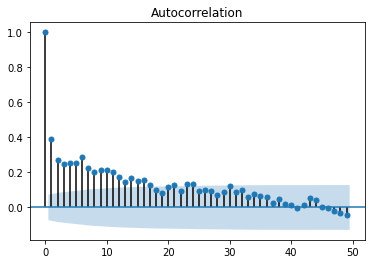

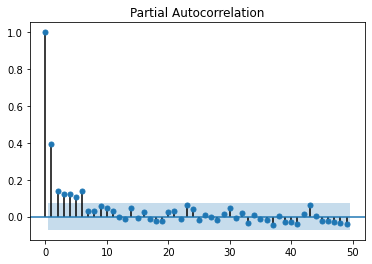

In [16]:
tsaplots.plot_acf(df, ax=None, lags=np.arange(50), use_vlines=True)
tsaplots.plot_pacf(df, ax=None, lags=np.arange(50), use_vlines=True)
plt.show()
# ACF and PACF plots display significant correlation between lags, and hence data is non-stationary. 
# One approach is to take out trend by rolling average and make it stationar for classical analysis.

In [17]:
trendcomp = (df.rolling(10).mean()).rolling(2).mean()
res = (df - trendcomp).dropna()
res

,Power
Time(year-month-day h:m:s),
2019-01-11,0.080667
2019-01-12,0.093614
2019-01-13,-0.080339
2019-01-14,0.035675
2019-01-15,-0.161014
...,...
2020-12-27,-0.184682
2020-12-28,-0.103401
2020-12-29,-0.100049


In [18]:
noise = df.iloc[:,0] - trendcomp.iloc[:,0] #- np.array(seasonalcomp).reshape(len(df),)
df['trendcomp'] = trendcomp.values
df.head()

,Power,trendcomp
Time(year-month-day h:m:s),,
2019-01-01,0.517645,NaN
2019-01-02,0.577124,NaN
2019-01-03,0.575022,NaN
2019-01-04,0.380803,NaN
2019-01-05,0.572974,NaN


In [22]:
df['noise'] = noise.values


,Power,trendcomp,noise
Time(year-month-day h:m:s),,,
2019-07-24,0.821721,0.658395,0.163326
2019-03-10,0.846767,0.788887,0.057880
2019-06-30,0.876718,0.632697,0.244021
2019-06-08,0.781800,0.730767,0.051033
2020-05-07,0.260922,0.616028,-0.355106
2020-08-29,0.556802,0.660689,-0.103886
2020-01-24,0.656591,0.426084,0.230506
2019-05-20,0.833704,0.678246,0.155458
2019-04-23,0.572957,0.783519,-0.210562


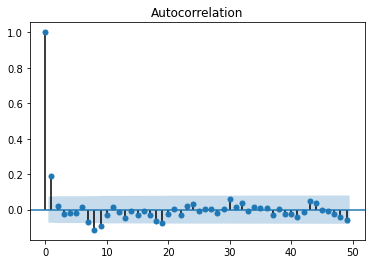

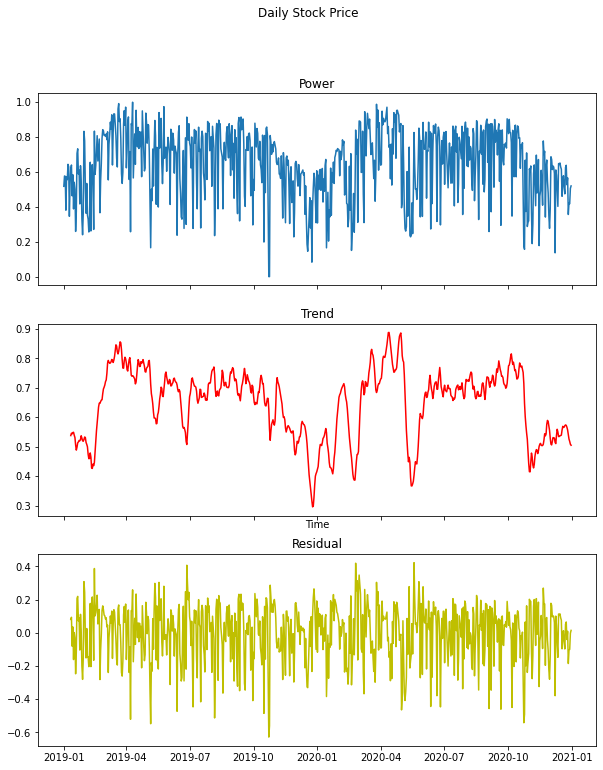

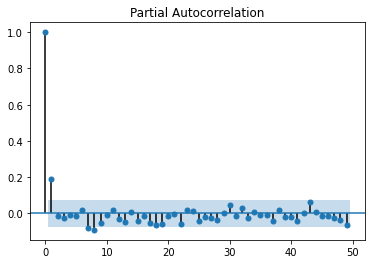

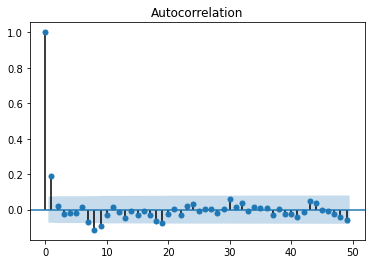

In [25]:
fig = plt.figure(1, figsize=[10,12])
fig.suptitle('Daily Stock Price')
fig1, fig2, fig3 = fig.subplots(nrows=3, ncols=1, sharex=True, sharey=False)
fig1.set_title('Power')
fig2.set_title('Trend')
fig3.set_title('Residual')
fig2.set_xlabel('Time')
fig1.plot(df.loc[:,'Power'])
fig2.plot(df.loc[:,'trendcomp'], 'r')
#fig3.plot(df.loc[:,'seasonalcomp'], 'g')
fig3.plot(df.loc[:,'noise'], 'y')
fig.show()
# taking auto correlations for stationary residual.
tsaplots.plot_pacf(noise.dropna(), ax=None, lags=np.arange(50), use_vlines=True)
tsaplots.plot_acf(noise.dropna(), ax=None, lags=np.arange(50), use_vlines=True)

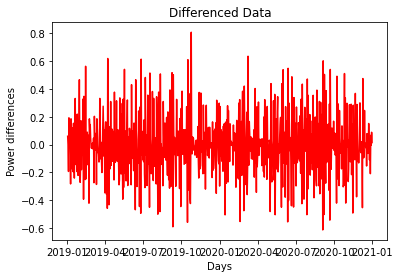

In [27]:
diff1 = df.loc[:,'Power'].diff(1)
nn = diff1.dropna() # - df.seasonalcomp[1:]
plt.plot(nn,'r')
plt.title('Differenced Data')
plt.xlabel('Days')
plt.ylabel('Power differences')
plt.show()

In [29]:
trainfrac = 0.90
df_train, df_test = train_test_split(df, train_size=trainfrac, shuffle=False, stratify=None)

In [30]:
#this function generates the input output
def input_output_generator(z,n):
    #generating input output sets for mlp models
    x_train = []
    y_train = []
    x_test = []
    y_test = z[math.floor(trainfrac*len(z)):]
    z_train = z[:math.floor(trainfrac*len(z))]
    for i in range(len(z_train)-n):
        x_train.append(z[i:i+n])
        y_train.append(z[i+n])
    for i in range(len(y_test)):
        x_test.append(z[len(z_train)-n+i:len(z_train)+i])
    return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

In [31]:
def Model_Build(Type,nodes,X_train, optimizer, learning_rate):
    # this function creates the model. Type is the type of deep learning model. It could be MLP, LSTM, ...
    # Nodes defines the sequence of nodes in different layers of network. It should be a list.
    # Optimizer and learning rate are used for compiling the model
    model = Sequential()
    if Type == 'MLP':
        model.add(Dense(nodes[0], activation='relu', input_shape=(X_train.shape[1],),
                        kernel_initializer='random_uniform', bias_initializer='RandomNormal'))
        for i in range(len(nodes)-1):
            model.add(Dense(nodes[i+1], activation='relu', kernel_initializer='random_uniform',
                            bias_initializer='RandomNormal'))

    if Type == 'Vanilla LSTM':
        model.add(LSTM(nodes, activation='relu', kernel_initializer='RandomNormal',
                       input_shape=(X_train[1,:].shape)))
        model.add(Dense(1))
    
    if Type == 'Stacked Unidirectional LSTM':
        model.add(LSTM(nodes[0], activation='relu', kernel_initializer='random_uniform', 
                       bias_initializer='RandomNormal', return_sequences=True, input_shape=(X_train[1,:].shape)))
        for i in range(len(nodes)-1):
            retseq = True
            if (i+1) == (len(nodes)-1):
                retseq = False
            model.add(LSTM(nodes[i+1], activation='relu', kernel_initializer='random_uniform', 
                           bias_initializer='RandomNormal',return_sequences=retseq))
        model.add(Dense(1, activation='relu', kernel_initializer='random_uniform',
                        bias_initializer='RandomNormal'))
    
    if Type == 'Bidirectional LSTM':
        model.add(Bidirectional(LSTM(nodes, activation='relu',
                                     kernel_initializer='random_uniform', bias_initializer='RandomNormal'),
                                merge_mode='ave', input_shape=(X_train[1,:].shape)))
        model.add(Dense(1))
    
    if Type == 'Stacked Bidirectional LSTM':
        model.add(Bidirectional(LSTM(nodes[0], activation='relu', return_sequences=True,
                                    kernel_initializer='random_uniform', bias_initializer='RandomNormal'),
                                merge_mode='ave', input_shape=(X_train[1,:].shape)))
        for i in range(len(nodes)-1):
            retseq = True
            if (i+1) == (len(nodes)-1):
                retseq = False
            model.add(Bidirectional(LSTM(nodes[i+1], activation='relu', return_sequences=retseq,
                                        kernel_initializer='random_uniform', bias_initializer='RandomNormal'),
                                   merge_mode='ave'))
        model.add(Dense(1, activation='relu', kernel_initializer='random_uniform',
                       bias_initializer='RandomNormal'))
    
    if Type == 'SimpleRNN':
        if type(nodes) == int:
            model.add(SimpleRNN(nodes, input_shape = (X_train.shape[1], X_train.shape[2]), activation = 'tanh',
                               kernel_initializer='random_uniform', bias_initializer='RandomNormal'))
        else:
            model.add(SimpleRNN(nodes[0], input_shape = (X_train.shape[1], X_train.shape[2]), activation = 'tanh',
                                return_sequences=True, kernel_initializer='random_uniform', 
                                bias_initializer='RandomNormal'))
            for i in range(len(nodes)-1):
                retseq = True
                if (i+1) == (len(nodes)-1):
                    retseq = False
                model.add(SimpleRNN(nodes[i+1], activation='tanh', return_sequences=retseq, 
                                    kernel_initializer='random_uniform',bias_initializer='RandomNormal'))
        model.add(Dense(1, activation='relu', kernel_initializer='random_uniform', bias_initializer='RandomNormal'))
    
    if Type == 'GRU':
        if type(nodes) == int:
            model.add(GRU(nodes, input_shape = (X_train.shape[1], X_train.shape[2]),
                          activation = 'tanh', return_sequences=False,
                         kernel_initializer='random_uniform', bias_initializer='RandomNormal'))
        else:
            model.add(GRU(nodes[0], input_shape = (X_train.shape[1], X_train.shape[2]),
                          activation = 'tanh', return_sequences=True,
                         kernel_initializer='random_uniform', bias_initializer='RandomNormal'))
            for i in range(len(nodes)-1):
                retseq = True
                model.add(GRU(nodes[i+1], activation='tanh', return_sequences=retseq,
                             kernel_initializer='random_uniform', bias_initializer='RandomNormal'))
        #model.add(GRU(1, activation='tanh', return_sequences=False,
         #            kernel_initializer='random_uniform', bias_initializer='RandomNormal'))
        model.add(Dense(1, activation='relu', kernel_initializer='random_uniform', bias_initializer='RandomNormal'))


    if optimizer == 'SGD':
        sgd = optimizers.SGD(lr=learning_rate, momentum=0)
        model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy', 'mse'])
    if optimizer == 'RMSprop':
        rmsprop = optimizers.RMSprop(lr=learning_rate, rho=0.9)
        model.compile(loss='mean_squared_error', optimizer=rmsprop, metrics=['accuracy', 'mse'])
    if optimizer == 'Adagrad':
        adagrad = optimizers.Adagrad(lr=learning_rate)
        model.compile(loss='mean_squared_error', optimizer=adagrad, metrics=['accuracy', 'mse'])
    if optimizer == 'Adadelta':
        adadelta = optimizers.Adadelta(lr=learning_rate, rho=0.95)
        model.compile(loss='mean_squared_error', optimizer=adadelta, metrics=['accuracy', 'mse'])
    if optimizer == 'Adam':
        adam = optimizers.Adam(learning_rate)
        model.compile(loss='mean_squared_error', optimizer=adam, metrics=['accuracy', 'mse'])
    return model


def Tune_epoch(Type, X_train, Y_train, nodes, val_split, epochs, batch_size, optimizer, learning_rate):
    #this funciton tunes number of epochs of the model.
    e = [0 for i in range(len(epochs))]
    ii = 0
    for i in epochs:
        model = Model_Build(Type,nodes,X_train, optimizer, learning_rate)
        history_lstm = model.fit(X_train, Y_train, validation_split=val_split, epochs=i, batch_size=batch_size, verbose=0, shuffle=False)
        e[ii] = history_lstm.history['val_loss'][-1]
        ii += 1
    return e


In [33]:
def Tune_nodes(Type, X_train, Y_train, nodes, val_split, epochs, batch_size, optimizer, learning_rate):
    #this function tunes number of nodes.
    e = {}
    if np.size(np.shape(nodes)) == 1:
        for i in nodes:
            model = Model_Build(Type, i, X_train, optimizer, learning_rate)
            history = model.fit(X_train, Y_train, validation_split=val_split, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)
            e[i] = history.history['val_loss'][-1]
    else:
        for i in range(np.shape(nodes)[0]):
            model = Model_Build(Type, nodes[i], X_train, optimizer, learning_rate)
            history = model.fit(X_train, Y_train, validation_split=val_split, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)
            e[i] = history.history['val_loss'][-1]
    return e

def Tune_optimizer(Type, X_train, Y_train, nodes, val_split, epochs, batch_size, optimizer, learning_rate):
    #this function tunes the optimizer and the learning rate.
    e = {}
    for i in range(len(optimizer)):
        for j in range(len(learning_rate)):
            model = Model_Build(Type, nodes, X_train, optimizer[i], learning_rate[j])
            history = model.fit(X_train, Y_train, validation_split=val_split, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)
            e[optimizer[i]+', rate='+str(learning_rate[j])] = history.history['val_loss'][-1]
    return e

def Tune_batch(Type, X_train, Y_train, nodes, val_split, epochs, batch_size, optimizer, learning_rate):
    #this function tunes the batch size.
    e = {}
    for i in batch_size:
        model = Model_Build(Type, nodes, X_train, optimizer, learning_rate)
        history = model.fit(X_train, Y_train, validation_split=val_split, epochs=epochs, batch_size=i, verbose=0, shuffle=False)
        e[i] = history.history['val_loss'][-1]
    return e

In [36]:
lag_mlp = 5 # lag is number of previous steps
X_train_mlp, Y_train_mlp, X_test_mlp, Y_test_mlp = input_output_generator(df['Power'].tolist(), lag_mlp)

In [37]:
#tuning optimizer. This can give us a good starting point.
opt = ['Adam', 'Adagrad']
lr = [0.001, 0.01]
nodes = [64,32,8,1]
e = Tune_optimizer('MLP', X_train_mlp, Y_train_mlp, nodes, validation_split, 50, 10, opt, lr)
optimizer = (min(e, key=e.get)).split(', ')[0]
learning_rate = float(((min(e, key=e.get)).split(', ')[1]).split('=')[1])
print(e)
dfff = pd.Dataframe(e)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adagrad.py:77: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adagrad, self).__init__(name, **kwargs)


{'Adam, rate=0.001': 0.035402338951826096, 'Adam, rate=0.01': 0.04012716934084892, 'Adagrad, rate=0.001': 0.21833650767803192, 'Adagrad, rate=0.01': 0.034233007580041885}


In [43]:
import pandas as pd
dfff = pd.DataFrame([e])
dfff.head()

,"Adam, rate=0.001","Adam, rate=0.01","Adagrad, rate=0.001","Adagrad, rate=0.01"
0,0.035402,0.040127,0.218337,0.034233


In [44]:
# tuning number of layers and nodes in MLP 
#we will give few candidates for comparing
nodes = [[200,100,50,1],[64,32,16,1],[128,64,16,1]]
e = Tune_nodes('MLP', X_train_mlp, Y_train_mlp, nodes, validation_split, 50, 10, optimizer, learning_rate)
e

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adagrad.py:77: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adagrad, self).__init__(name, **kwargs)


{0: 0.033350203186273575, 1: 0.033954329788684845, 2: 0.033974237740039825}

In [52]:
nodes_mlp = [200, 100, 50, 1]
#tune batch size
batch = [10, 30]
e = Tune_batch('MLP', X_train_mlp, Y_train_mlp, nodes_mlp, validation_split, 50, batch, optimizer, learning_rate)
batch_size = int(min(e, key=e.get))
batch_size = 10
nodes_mlp = [100, 50]
optimizer = 'Adam'
learning_rate = 0.001

Epoch 1/200
49/49 [==============================] - 1s 7ms/step - loss: 0.2995 - accuracy: 0.0000e+00 - mse: 0.2995 - val_loss: 0.1871 - val_accuracy: 0.0000e+00 - val_mse: 0.1871
Epoch 2/200
49/49 [==============================] - 0s 3ms/step - loss: 0.1654 - accuracy: 0.0000e+00 - mse: 0.1654 - val_loss: 0.1772 - val_accuracy: 0.0000e+00 - val_mse: 0.1772
Epoch 3/200
49/49 [==============================] - 0s 3ms/step - loss: 0.1633 - accuracy: 0.0000e+00 - mse: 0.1633 - val_loss: 0.1772 - val_accuracy: 0.0000e+00 - val_mse: 0.1772
Epoch 4/200
49/49 [==============================] - 0s 3ms/step - loss: 0.1632 - accuracy: 0.0000e+00 - mse: 0.1632 - val_loss: 0.1771 - val_accuracy: 0.0000e+00 - val_mse: 0.1771
Epoch 5/200
49/49 [==============================] - 0s 4ms/step - loss: 0.1630 - accuracy: 0.0000e+00 - mse: 0.1630 - val_loss: 0.1770 - val_accuracy: 0.0000e+00 - val_mse: 0.1770
Epoch 6/200
49/49 [==============================] - 0s 3ms/step - loss: 0.1629 - accuracy: 0.0

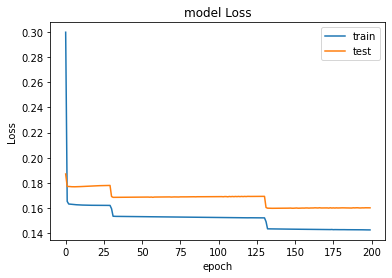

In [53]:
model_mlp = Model_Build('MLP', nodes_mlp, X_train_mlp, optimizer, learning_rate)
history_mlp = model_mlp.fit(X_train_mlp, Y_train_mlp, validation_split=validation_split, epochs=200,
                            batch_size=batch_size, verbose=1, shuffle=False)
plt.plot(history_mlp.history['loss'])
plt.plot(history_mlp.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [54]:
model_mlp.save('univariate_solarsite1.h5')

In [55]:
trainprediction_mlp = model_mlp.predict(X_train_mlp)
testprediction_mlp = model_mlp.predict(X_test_mlp)
trainprediction_mlp = pd.DataFrame(index=df.index[lag_mlp:len(df)-len(X_test_mlp)], data=trainprediction_mlp)
testprediction_mlp = pd.DataFrame(index=df.index[len(df)-len(X_test_mlp):], data=testprediction_mlp)

3/3 [==============================] - 0s 4ms/step


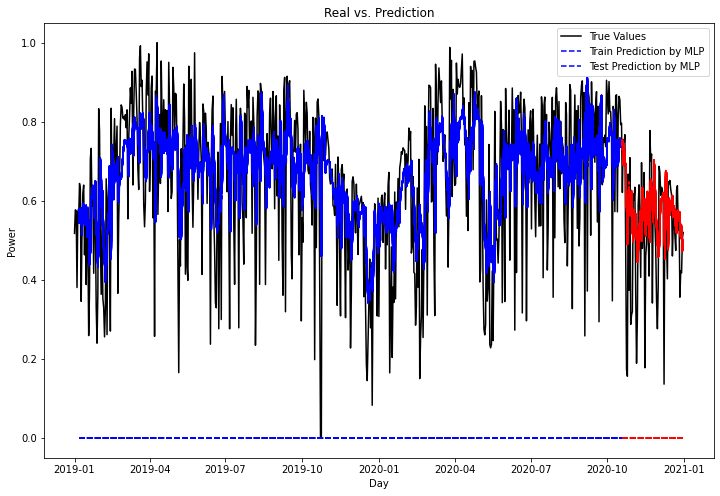

In [56]:
plt.figure(figsize=(12,8))
plt.plot(df.index, df['Power'], 'k')
plt.plot(trainprediction_mlp, '--b')
plt.plot(testprediction_mlp, '--r')
plt.title('Real vs. Prediction')
plt.ylabel('Power')
plt.xlabel('Day')
plt.legend(['True Values', 'Train Prediction by MLP', 'Test Prediction by MLP'], loc='best')
plt.show()

In [62]:
Metrics = {}
Metrics['RMSE_MLP'] = RMSE(Y_test_mlp, testprediction_mlp[0])
Metrics['MAPE_MLP'] = MAPE(Y_test_mlp, testprediction_mlp[0])
Metrics['SMAPE_MLP'] = SMAPE(Y_test_mlp, testprediction_mlp[0])
Metrics['MSLE_MLP'] = MSLE(Y_test_mlp, testprediction_mlp[0])
Metrics
# Y_test_mlp.shape, testprediction_mlp.shape[0]

{'RMSE_MLP': 0.16569711892875946,
 'MAPE_MLP': 38.45399854804244,
 'SMAPE_MLP': 26.659168775241408,
 'MSLE_MLP': 0.013134158674277948}

In [63]:
def input_output_generator_LSTM(z,n):
    #generating input output sets for LSTM models
    x_train = []
    y_train = []
    x_test = []
    y_test = z[math.floor(trainfrac*len(z)):]
    z_train = z[:math.floor(trainfrac*len(z))]
    for i in range(len(z_train)-n):
        x_train.append(z[i:i+n])
        y_train.append(z[i+n])
    for i in range(len(y_test)):
        x_test.append(z[len(z_train)-n+i:len(z_train)+i])
    x_train = np.array(x_train)
    x_test = np.array(x_test)
    x_train_lstm = np.reshape(x_train,(x_train.shape[0], x_train.shape[1],1))
    x_test_lstm = np.reshape(x_test,(x_test.shape[0], x_test.shape[1],1))
    return x_train_lstm, np.array(y_train), x_test_lstm, np.array(y_test)

In [64]:
lag_lstm = 3
X_train_lstm, Y_train_lstm, X_test_lstm, Y_test_lstm = input_output_generator_LSTM(df['Power'].tolist(),
                                                                                   lag_lstm)

In [65]:
#tuning optimizer. This can give us a good starting point.
opt = ['Adam', 'Adagrad', 'SGD', 'RMSprop', 'Adadelta']
lr = [0.001, 0.01, 0.1]
e = Tune_optimizer('Vanilla LSTM', X_train_lstm, Y_train_lstm, 50, validation_split, 50, 10, opt, lr)
optimizer = (min(e, key=e.get)).split(', ')[0]
learning_rate = float(((min(e, key=e.get)).split(', ')[1]).split('=')[1])
e

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adagrad.py:77: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adagrad, self).__init__(name, **kwargs)
/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adadelta.py:77: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adadelta, self).__init__(name, **kwargs)


{'Adam, rate=0.001': 0.03855873644351959,
 'Adam, rate=0.01': 0.03597117215394974,
 'Adam, rate=0.1': 0.043531302362680435,
 'Adagrad, rate=0.001': 0.07225651293992996,
 'Adagrad, rate=0.01': 0.03377891331911087,
 'Adagrad, rate=0.1': 0.03438057377934456,
 'SGD, rate=0.001': 0.03449368104338646,
 'SGD, rate=0.01': 0.03393617644906044,
 'SGD, rate=0.1': 0.033360883593559265,
 'RMSprop, rate=0.001': 0.0354820117354393,
 'RMSprop, rate=0.01': 0.03428839519619942,
 'RMSprop, rate=0.1': 0.035057101398706436,
 'Adadelta, rate=0.001': 0.4785226881504059,
 'Adadelta, rate=0.01': 0.040578145533800125,
 'Adadelta, rate=0.1': 0.03371693566441536}

In [66]:
# tuning number of nodes in LSTM layer
nodes = [1, 10, 50, 100, 200]
e = Tune_nodes('Vanilla LSTM', X_train_lstm, Y_train_lstm, nodes, validation_split, 50, 10, optimizer, learning_rate)
nodes = int(min(e, key=e.get))


In [67]:
nodes

200

In [68]:
#tune batch size
batch = [1, 10, 30]
e = Tune_batch('Vanilla LSTM', X_train_lstm, Y_train_lstm, nodes, validation_split, 50,
               batch, optimizer, learning_rate)
batch_size = int(min(e, key=e.get))
batch_size

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


10

In [71]:
nodes = 100
batch_size=10
learning_rate = 0.01
optimizer = 'Adam'
model_lstm = Model_Build('Vanilla LSTM', nodes, X_train_lstm, optimizer, learning_rate)
model_lstm.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 100)               40800     
                                                                 
 dense_82 (Dense)            (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
49/49 [==============================] - 2s 12ms/step - loss: 0.0667 - accuracy: 0.0020 - mse: 0.0667 - val_loss: 0.0398 - val_accuracy: 0.0000e+00 - val_mse: 0.0398
Epoch 2/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0409 - accuracy: 0.0020 - mse: 0.0409 - val_loss: 0.0381 - val_accuracy: 0.0000e+00 - val_mse: 0.0381
Epoch 3/100
49/49 [==============================] - 1s 11ms/step - loss: 0.0396 - accuracy: 0.0020 - mse: 0.0396 - val_loss: 0.0374 - val_accuracy: 0.0000e+00 - val_mse: 0.0374
Epoch 4/100
49/49 [==============================] - 1s 12ms/step - loss: 0.0388 - accuracy: 0.0020 - mse: 0.0388 - val_loss: 0.0362 - val_accuracy: 0.0000e+00 - val_mse: 0.0362
Epoch 5/100
49/49 [==============================] - 1s 13ms/step - loss: 0.0380 - accuracy: 0.0020 - mse: 0.0380 - val_loss: 0.0353 - val_accuracy: 0.0000e+00 - val_mse: 0.0353
Epoch 6/100
49/49 [==============================] - 0s 10ms/step - loss: 0.0373 - accuracy: 0.0020 - mse: 0.03

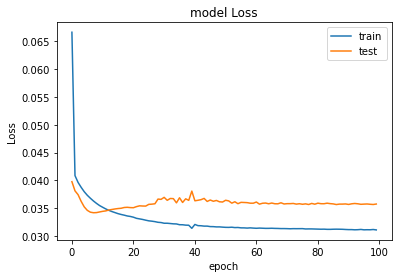

In [72]:
history_lstm = model_lstm.fit(X_train_lstm, Y_train_lstm, validation_split=validation_split, 
                              epochs=100, batch_size=batch_size, verbose=1, shuffle=False)
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [73]:
trainprediction_lstm = model_lstm.predict(X_train_lstm)
testprediction_lstm = model_lstm.predict(X_test_lstm)
trainprediction_lstm = pd.DataFrame(index=df.index[lag_lstm:len(df)-len(X_test_lstm)], data=trainprediction_lstm)
testprediction_lstm = pd.DataFrame(index=df.index[len(df)-len(X_test_lstm):], data=testprediction_lstm)

3/3 [==============================] - 0s 10ms/step


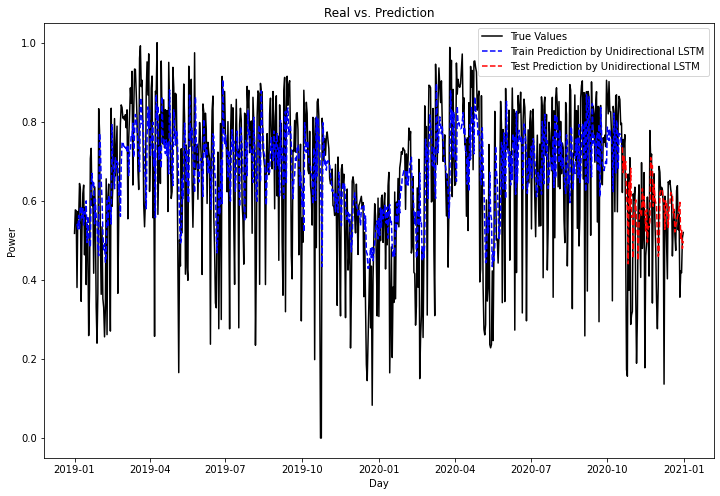

In [75]:
plt.figure(figsize=(12,8))
plt.plot(df.index, df.Power, 'k')
plt.plot(trainprediction_lstm, '--b')
plt.plot(testprediction_lstm, '--r')
plt.title('Real vs. Prediction')
plt.ylabel('Power')
plt.xlabel('Day')
plt.legend(['True Values', 'Train Prediction by Unidirectional LSTM', 'Test Prediction by Unidirectional LSTM']
           , loc='best')
plt.show()

In [76]:
lag_sul = 5
X_train_sul, Y_train_sul, X_test_sul, Y_test_sul = input_output_generator_LSTM(df['Power'].tolist(),
                                                                               lag_sul)

In [77]:
#tuning optimizer. This can give us a good starting point.
opt = ['Adam', 'Adadelta']
lr = [0.001, 0.1]
e = Tune_optimizer('Stacked Unidirectional LSTM', X_train_sul, Y_train_sul, [100, 100], validation_split, 50, 10, opt, lr)
optimizer = (min(e, key=e.get)).split(', ')[0]
learning_rate = float(((min(e, key=e.get)).split(', ')[1]).split('=')[1])
e

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adadelta.py:77: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adadelta, self).__init__(name, **kwargs)


{'Adam, rate=0.001': 0.032581113278865814,
 'Adam, rate=0.1': 0.5112670660018921,
 'Adadelta, rate=0.001': 0.5112670660018921,
 'Adadelta, rate=0.1': 0.033149413764476776}

In [80]:
nodes = [100,50]
optimizer = 'Adam'
learning_rate = 0.001
batch_size = 10
model_sul = Model_Build('Stacked Unidirectional LSTM', nodes, X_train_sul, optimizer, learning_rate)
model_sul.summary()

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_35 (LSTM)              (None, 5, 100)            40800     
                                                                 
 lstm_36 (LSTM)              (None, 50)                30200     
                                                                 
 dense_88 (Dense)            (None, 1)                 51        
                                                                 
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
49/49 [==============================] - 5s 39ms/step - loss: 0.1839 - accuracy: 0.0041 - mse: 0.1839 - val_loss: 0.0321 - val_accuracy: 0.0000e+00 - val_mse: 0.0321
Epoch 2/100
49/49 [==============================] - 1s 23ms/step - loss: 0.0411 - accuracy: 0.0020 - mse: 0.0411 - val_loss: 0.0332 - val_accuracy: 0.0000e+00 - val_mse: 0.0332
Epoch 3/100
49/49 [==============================] - 1s 25ms/step - loss: 0.0408 - accuracy: 0.0020 - mse: 0.0408 - val_loss: 0.0339 - val_accuracy: 0.0000e+00 - val_mse: 0.0339
Epoch 4/100
49/49 [==============================] - 1s 22ms/step - loss: 0.0404 - accuracy: 0.0020 - mse: 0.0404 - val_loss: 0.0338 - val_accuracy: 0.0000e+00 - val_mse: 0.0338
Epoch 5/100
49/49 [==============================] - 1s 20ms/step - loss: 0.0400 - accuracy: 0.0020 - mse: 0.0400 - val_loss: 0.0338 - val_accuracy: 0.0000e+00 - val_mse: 0.0338
Epoch 6/100
49/49 [==============================] - 0s 9ms/step - loss: 0.0397 - accuracy: 0.0020 - mse: 0.03

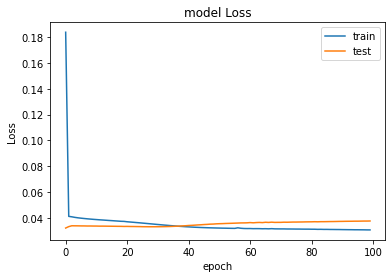

In [81]:
history_sul = model_sul.fit(X_train_sul, Y_train_sul, validation_split=validation_split, epochs=100,
                            batch_size=batch_size, verbose=1, shuffle=False)
plt.plot(history_sul.history['loss'])
plt.plot(history_sul.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [82]:
trainprediction_sul = model_sul.predict(X_train_sul)
testprediction_sul = model_sul.predict(X_test_sul)
trainprediction_sul = pd.DataFrame(index=df.index[lag_sul:len(df)-len(X_test_sul)], data=trainprediction_sul)
testprediction_sul = pd.DataFrame(index=df.index[len(df)-len(X_test_sul):], data=testprediction_sul)

3/3 [==============================] - 0s 7ms/step


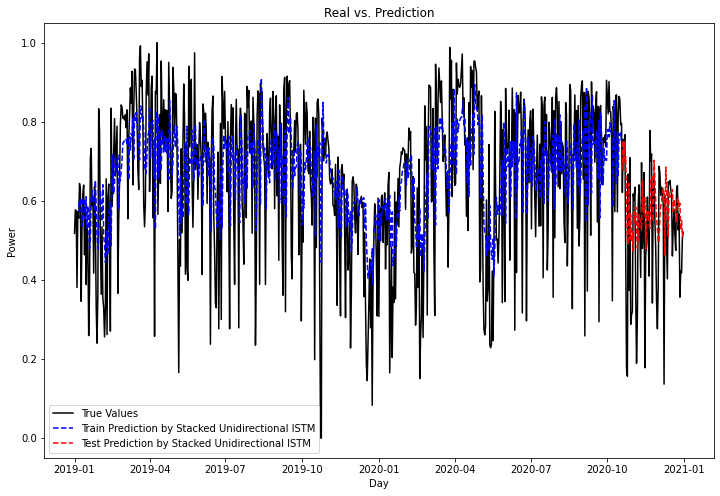

In [83]:
plt.figure(figsize=(12,8))
plt.plot(df.index, df.Power, 'k')
plt.plot(trainprediction_sul, '--b')
plt.plot(testprediction_sul, '--r')
plt.title('Real vs. Prediction')
plt.ylabel('Power')
plt.xlabel('Day')
plt.legend(['True Values', 'Train Prediction by Stacked Unidirectional lSTM', 'Test Prediction by Stacked Unidirectional lSTM'],
           loc='best')
plt.show()